# Question 4 du projet

In [27]:
import numpy as np
import pandas as pd
import spacy
import time
import matplotlib.pyplot as plt
import warnings
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
warnings.filterwarnings('ignore')

Nous n'avons pas réussi à utiliser les autres datasets cités dns l'énoncé. Ils ne s'ouvraient pas sur le Git.
Nous avons donc cheché d'autres dataset. En premier lieu nous avons utilisé un dataset ressemblant à celui des questions précédantes (https://www.kaggle.com/alaakhaled/conll003-englishversion#test.txt) trouvé sur Kaggle. Cependant nous ne disposons pas de vecteurs pour les mots de ce dataset, mais seulement de leur entité. Il nous faut donc, après lecture et parsing du dataset, vectoriser ces mots. Nous utilisons ici l'outil Spacy (juste pour le Word Embedding, pas pour le NER). Puis nous appliquons notre régression logistique en one vs one pour ce dataset. Ensuite nous irons plus loin : on prend un texte quelconque, on trouve les entité et les embeddings avec Spacy et on applique notre régression. Nous l'appliquerons en One vs Rest sur les textes. 

## Préparation des données 

In [17]:
with open(r"train.txt", 'r') as f2:
    data = f2.read()

In [18]:
# Partie 1 : on recupère le contenu sous la forme d'un tableau [mot , label d'entité]

def txt_to_ner(txt):
    out = []
    buff = []
    for c in txt:
        if c == '\n':
            out.append(''.join(buff))
            buff = []
        else:
            buff.append(c)
    else:
        if buff:
            out.append(''.join(buff))

    lignes = out

    tab=[]
    for l in lignes:
        if len(l)>5:
            tab.append([l.split()[0],l.split()[-1]])

    return np.array(tab)

tab=txt_to_ner(data)

In [19]:
# partie 2 : vectoriser les mots avec spacy

# on peut accelerer cette étape en ne prenant que la tokenization de spacy,
# mais vu qu'on aura besoin des entity plus loin, autant faire tout le pipeline ici


nlp = spacy.load("en_core_web_sm")

taille_train=10000
print("temps d'attente estimé : ", taille_train*78.5/10000, " secondes." )
tab_token=np.array([[nlp(str(x[0])).vector,x[1]] for x in tab[1:taille_train]])   # on tokenize les mots

# tab_token a pour taille (taille_train , 2)
# à chaque ligne, le premier element est le vecteur du mot et le 2eme est le label de l'entité

X_train=np.array([x[0] for x in tab_token])
Y_train_ent=np.array([[x[1]] for x in tab_token])

temps d'attente estimé :  78.5  secondes.


In [20]:
# derniere etape avant le train : changer les label en numéro de classe
# on a : "I-LOC", "B-ORG","O","B-PER","I-PER","I-MISC","B-MISC","I-ORG","B-LOC" comme entités possibles

l=["I-LOC", "B-ORG","O","B-PER","I-PER","I-MISC","B-MISC","I-ORG","B-LOC"]

def modif_df_3(df,entity):
    # entity est une liste de label d'entités
    dataframe=df
    for k in range(len(dataframe)):
        a=dataframe[k]
        for ent in range(len(entity)):
            if a==entity[ent]:
                dataframe[k] = [ent]
    return np.array(dataframe)

Y_train=modif_df_3(Y_train_ent,l)

In [21]:
# on prépare l'échantillon de test 
with open(r"test.txt", 'r') as f3:
    test = f3.read()

tab_test=txt_to_ner(test)
taille_test=1000
print("temps d'attente estimé : ", taille_test*78.5/10000 , " secondes.")
tab_token_test=np.array([[nlp(str(x[0])).vector,x[1]] for x in tab_test[1:taille_test]])

X_test=np.array([x[0] for x in tab_token_test])
Y_test_ent=np.array([[x[1]] for x in tab_token_test])

Y_test=modif_df_3(Y_test_ent,l)

temps d'attente estimé :  7.85  secondes.


## Entrainement 

In [23]:
clf=OneVsOneClassifier(LogisticRegression(random_state=0)).fit(X_train, Y_train)

In [43]:
def print_confusion(matrice):
    df=pd.DataFrame(matrice, columns = ["I-LOC", "B-ORG","O","B-PER","I-PER","I-MISC","B-MISC","I-ORG","B-LOC"],
                    index = ["classe I-LOC", "classe B-ORG","classe O","classe B-PER",
                               "classe I-PER","classe I-MISC","classe B-MISC","classe I-ORG","classe B-LOC"])
    print(df)

In [44]:
Y_pred=clf.predict(X_test)

In [45]:
print_confusion(confusion_matrix(Y_test,Y_pred))

               I-LOC  B-ORG    O  B-PER  I-PER  I-MISC  B-MISC  I-ORG  B-LOC
classe I-LOC       5      0    0      0      0       0       0      0      0
classe B-ORG       0      0    0      0      0       0       0      0      2
classe O           0      0  798      2      1       1       0      0      0
classe B-PER       1     15    1     21     16       0       1      9      5
classe I-PER       0     11    0     24     14       0       1      2      3
classe I-MISC      0      0    0      0      1       6       1      0      0
classe B-MISC      0      0    1      0      1       0      15      0      0
classe I-ORG       0      0    0      0      0       0       0      1      0
classe B-LOC       0      1    0      0      1       0       2      2     34


Plusieurs aspects sont interressant à commenter dans cette matrice de confusion. Tout d'abord de manière globale, notre classification ne se trompe pas trop dans la prédiction d'entité à partir des vecteurs de Spacy. Cependant 26 personnes (I-Per ou B-Per) sont classées comme des organisation par notre regression logistique. Afin de pouvoir analyser avec plus de clarté les résultats nous allons utiliser une stratégie One vs Rest et appliquer la démarche ci-dessus sur un texte quelconque.

## Essai sur un texte

Une faille de notre raisonnement est que pour nous créer un échantillon de train et de test, nous considérons le NER de Spacy comme étant parfait. Cependant, en comparaison à ce que l'on pourrait faire comme NER (voir notre question 2), cela n'est pas trop grave de le considerer comme parfait (ce n'est pas le cas).

In [111]:
def txt_to_exploitable(data):
    texte=nlp(data)
    X, Y =[], []
    for token in texte:
        X.append(token.vector)
        if token.ent_type_=='PERSON':
            Y.append(1)
        else:
            Y.append(0)
    return np.array(X) , np.array(Y)

### Echantillon d'entrainement :

On prend un extrait d'article du New York Times pour l'entrainement. (https://www.nytimes.com/2016/06/30/nyregion/mayor-de-blasios-counsel-to-leave-next-month-to-lead-police-review-board.html) (il nous fallait de l'anglais pour ne pas avoir à télécharger d'autres package Spacy, et cet article était gratuità lire). 

In [112]:
with open(r"ny_times.txt", 'r') as f2:
    data = f2.read()

X_train, Y_train = txt_to_exploitable(data)

In [119]:
print("Cet article contient" , Y_train.sum(), "noms propres.")

Cet article contient 56 noms propres.


### Echantillon de test :

#### TEST A : Oliver Twist 

In [117]:
with open(r"oliver.txt", 'r') as f2:
    data = f2.read()
    
X_test_a, Y_test_a = txt_to_exploitable(data)

In [121]:
print("Cet extrait contient" , Y_test_a.sum(), "noms propres.")

Cet extrait contient 10 noms propres.


#### TEST B : article wikipedia sur le Brexit, un peu modifié.

In [128]:
with open(r"brexit.txt", 'r') as f2:
    data = f2.read()
    
X_test_b, Y_test_b = txt_to_exploitable(data)

In [129]:
print("Cet article contient" , Y_test_b.sum(), "noms propres.")

Cet article contient 18 noms propres.


## Resultats 

In [130]:
clf=LogisticRegression(random_state=0).fit(X_train,Y_train)

In [139]:
def print_confusion(matrice):
    df=pd.DataFrame(matrice, index = ['classe negative', 'classe positive'],
                    columns = ['prédit negatif', 'prédit positif'])
    print(df)

In [140]:
Y_pred_a=clf.predict(X_test_a)
Y_pred_b=clf.predict(X_test_b)

print("Matrice de confusion test A : \n")
print(print_confusion(confusion_matrix(Y_test_a,Y_pred_a)))
print("Matrice de confusion test B : \n")
print(print_confusion(confusion_matrix(Y_test_b,Y_pred_b)))

Matrice de confusion test A : 

                 prédit negatif  prédit positif
classe negative             449               0
classe positive               4               6
None
Matrice de confusion test B : 

                 prédit negatif  prédit positif
classe negative             591               4
classe positive               9               9
None


In [142]:
report=classification_report(Y_test_b,Y_pred_b,output_dict=True,target_names=['classe 0', 'classe 1'])
acc=clf.score(X_test_b,Y_test_b)
df=pd.DataFrame(report)['classe 1']
df['accuracy']=acc
print(df)

precision     0.692308
recall        0.500000
f1-score      0.580645
support      18.000000
accuracy      0.978793
Name: classe 1, dtype: float64


Les performances ne sont pas très satisfaisantes (EXPLICATIONS ???). On peut en conclure qu'après l'étape de Word Embedding, le NER ne consiste pas en une simple régression. Nous tenterons de construire notre NER en question 2 ci-après et verrons les difficultés rencontrées.
On remarque bien ici que l'accuracy n'est pas très significative dans ce type de problème.

### Courbe ROC

In [147]:
Y_score_b =clf.decision_function(X_test_b)

In [148]:
fpr, tpr, _ = roc_curve(Y_test_b, Y_score_b)
roc_auc = auc(fpr, tpr)

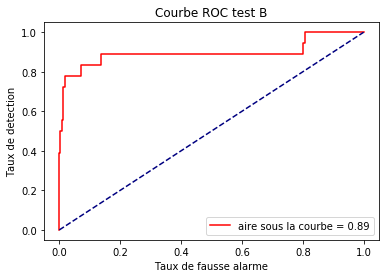

In [149]:
plt.figure()
plt.plot(fpr, tpr, color='red', label='aire sous la courbe = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Taux de fausse alarme')
plt.ylabel('Taux de detection')
plt.title('Courbe ROC test B')
plt.legend(loc="lower right")
plt.show()

On remarque que la courbe est moins bonne que celle obtenue en question 1 sans être catastrophique. De même l'aire sous la courbe reste assez élevée mais loin de la très bonne valeur obtenue à la question 1.